In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def table32(data):
    table = np.zeros(6)
    
    for i in range(len(data)):
        table[int(data[i])] += 1
        
    return table

def chi32(table):
    p = table[0]; q = table[1]; r = table[2]; s = table[3]; t = table[4]; u = table[5]
    N = p+q+r+s+t+u; R = p+r+t; S = q+s+u
    
    if R == 0 or S == 0:
        T = 0
    elif p+q == 0:
        if r+s == 0:
            if t+u == 0:
                T = 0
            else:
                T = ((N*t - (t+u)*R)**2)/((t+u)*R*S)
        else:
            if t+u == 0:
                T = ((N*r - (r+s)*R)**2)/((r+s)*R*S)
            else:
                T = ((N*r - (r+s)*R)**2)/((r+s)*R*S) + ((N*t - (t+u)*R)**2)/((t+u)*R*S)
    else:
        if r+s == 0:
            if t+u == 0:
                T = ((N*p - (p+q)*R)**2)/((p+q)*R*S)
            else:
                T = ((N*p - (p+q)*R)**2)/((p+q)*R*S) + ((N*t - (t+u)*R)**2)/((t+u)*R*S)
        else:
            if t+u == 0:
                T = ((N*p - (p+q)*R)**2)/((p+q)*R*S) + ((N*r - (r+s)*R)**2)/((r+s)*R*S)
            else:
                T = ((N*p - (p+q)*R)**2)/((p+q)*R*S) + ((N*r - (r+s)*R)**2)/((r+s)*R*S) + ((N*t - (t+u)*R)**2)/((t+u)*R*S)
    
    return T

In [3]:
def generateData(N):
    gp = np.zeros((N,2))
    
    for i in range(N):
        gp[i][0] = random.randint(0,2)
        gp[i][1] = random.randint(0,1)
        
    data32 = np.zeros(N)
    
    for i in range(N):
        if gp[i][0] == 0 and gp[i][1] == 0:
            data32[i] = 0
        elif gp[i][0] == 0 and gp[i][1] == 1:
            data32[i] = 1
        elif gp[i][0] == 1 and gp[i][1] == 0:
            data32[i] = 2
        elif gp[i][0] == 1 and gp[i][1] == 1:
            data32[i] = 3
        elif gp[i][0] == 2 and gp[i][1] == 0:
            data32[i] = 4
        else:
            data32[i] = 5
    
    return data32

In [4]:
def RR(epsilon,g,m):
    gRR = np.zeros(len(g))
    
    for i in range(len(g)):
        rand = random.random()
        if rand >= m/(math.exp(epsilon)+m-1):
            gRR[i] = g[i]
        else:
            gRR[i] = int(rand*(math.exp(epsilon)+m-1))
    
    return gRR

def recoverRR(epsilon,gRR,n,m):
    rRR = np.zeros(m)
    for i in range(m):
        rRR[i] = round(((math.exp(epsilon)+m-2)/(math.exp(epsilon)-1))*gRR[i] - ((n-gRR[i])/(math.exp(epsilon)-1)))
        if rRR[i] < 0:
            rRR[i] = 0
    rRR = rRR*(np.sum(gRR)/np.sum(rRR))
        
    return rRR

In [5]:
def Diff(N,M,epsilon):
    diff = np.zeros((2,M))
    stats32 = np.zeros((M,2)); rstats32 = np.zeros(M)
    
    for i in range(M): # i: SNP, generate statistics for M SNPs
        data = generateData(N)
        stats32[i][0] = chi32(table32(data))
        stats32[i][1] = i
        RRtbl32 = table32(RR(epsilon,data,6))
        rtbl32 = recoverRR(epsilon,RRtbl32,N,6)
        rstats32[i] = chi32(rtbl32)
    
    sstats32 = sorted(stats32, key=lambda x:(x[0]),reverse=True)
    s32 = np.zeros(M); rs32 = np.zeros(M); ls32 = np.zeros(M)
    for i in range(M):
        s32[i] = sstats32[i][0]
        
        rs32[i] = rstats32[int(sstats32[i][1])]
        diff[0][i] = math.fabs(s32[i]-rs32[i])
        
        ls32[i] = s32[i] + np.random.laplace(loc=0.0, scale=(4*N/(N+2))/epsilon, size=1)
        if ls32[i] < 0:
            ls32[i] = 0
        diff[1][i] = math.fabs(s32[i]-ls32[i])
    
    return diff

def evaluation(N,M,epsilon):
    diff = np.zeros((2,M))
    for j in range(4):
        diff += Diff(N,M,epsilon)
    diff /= 4
    return diff

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


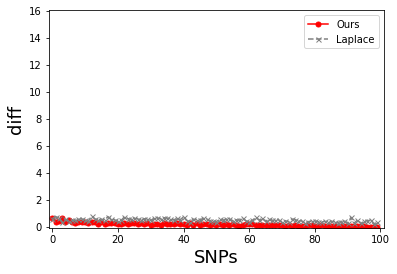

In [6]:
N = 1000; M = 100; epsilon = 7

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 16.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Laplace")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_32_N=1000_epsilon=7.png")
fig.savefig("figs/diff_32_N=1000_epsilon=7.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


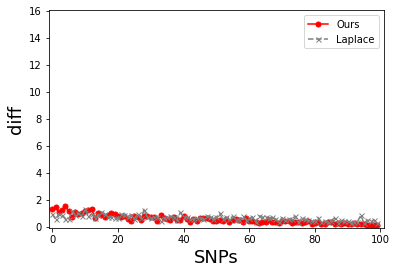

In [7]:
N = 1000; M = 100; epsilon = 5

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 16.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Laplace")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_32_N=1000_epsilon=5.png")
fig.savefig("figs/diff_32_N=1000_epsilon=5.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


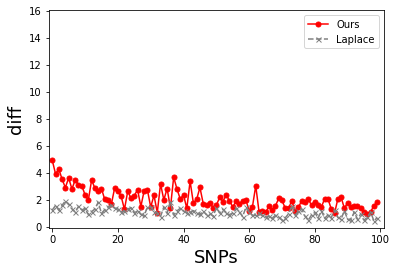

In [8]:
N = 1000; M = 100; epsilon = 3

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 16.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Laplace")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_32_N=1000_epsilon=3.png")
fig.savefig("figs/diff_32_N=1000_epsilon=3.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


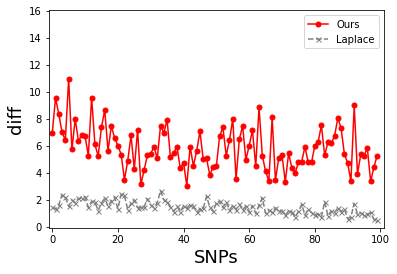

In [9]:
N = 1000; M = 100; epsilon = 2

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 16.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Laplace")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_32_N=1000_epsilon=2.png")
fig.savefig("figs/diff_32_N=1000_epsilon=2.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


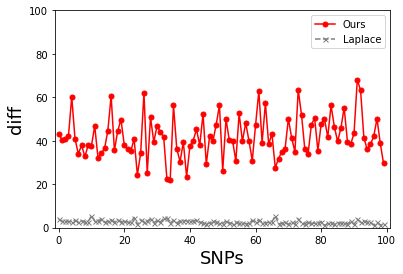

In [10]:
N = 1000; M = 100; epsilon = 1

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 100.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Laplace")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_32_N=1000_epsilon=1.png")
fig.savefig("figs/diff_32_N=1000_epsilon=1.eps", bbox_inches="tight", pad_inches=0.05)